<a href="https://colab.research.google.com/github/sarthak-srivastava/Learning-Iterative-Image-Reconstruction/blob/master/NNFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to the paper: http://www.ais.uni-bonn.de/behnke/papers/ijcai01.pdf

In [1]:
#Lets get started by loading our basic dependencies
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import argparse


In [3]:
from tqdm import tqdm
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("MNIST_data/")

In [5]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [6]:
x_train = mnist.train.images[:55000,:]
x_train.shape

(55000, 784)

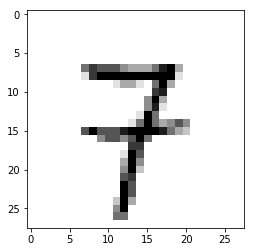

In [7]:
#Let's have a look at a random image
RandomNum = random.randint(0,55000)
image = x_train[RandomNum].reshape([28,28])
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

In [8]:
x =[0]*55000
image_label = [0]*55000
image_train = [0]*55000
for i in range(55000):
  x[i] = x_train[i].reshape([28,28])
  image_label[i] = x_train[i].reshape([784,1])
  image_train[i] = resize(x[i], (14,14))

 

/home/sarthak/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


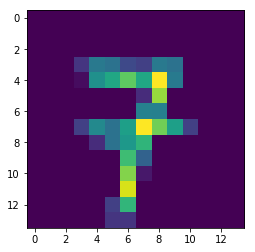

In [9]:
plt.imshow(image_train[RandomNum])
plt.show()

In [10]:
for i in range(55000):
  image_train[i] = image_train[i].reshape([196,1]) 

In [11]:
from itertools import product

from stackrnn import StackRNNCell, StackLSTMCell, RecurrentWrapper

In [13]:


# hyperparameter search on algorithmic patterns

n_iterations =55
n_min = 2
n_max_train = 15
n_max_val = 19
n_max_test = 60
n_img_per_iter = 1000
model ="srnn"
hidden_sizes = [20, 40, 100]
hidden_layers = [1]
sgd_lrs = [0.1, 0.01, 0.001]
n_stacks = [1, 2, 5, 10]
ks = [1, 2]




In [14]:
for hidden_size, n_layers, sgd_lr, n_stack, k in \
    product(hidden_sizes, hidden_layers, sgd_lrs, n_stacks, ks):
    print("=" * 60)
    print(" units: ", hidden_size)
    print(" layers: ", n_layers)
    print(" lr: ", sgd_lr)
    print(" stacks: ", n_stack)
    print(" k: ", k)
    print("=" * 60)
    
  

 units:  20
 layers:  1
 lr:  0.1
 stacks:  1
 k:  1
 units:  20
 layers:  1
 lr:  0.1
 stacks:  1
 k:  2
 units:  20
 layers:  1
 lr:  0.1
 stacks:  2
 k:  1
 units:  20
 layers:  1
 lr:  0.1
 stacks:  2
 k:  2
 units:  20
 layers:  1
 lr:  0.1
 stacks:  5
 k:  1
 units:  20
 layers:  1
 lr:  0.1
 stacks:  5
 k:  2
 units:  20
 layers:  1
 lr:  0.1
 stacks:  10
 k:  1
 units:  20
 layers:  1
 lr:  0.1
 stacks:  10
 k:  2
 units:  20
 layers:  1
 lr:  0.01
 stacks:  1
 k:  1
 units:  20
 layers:  1
 lr:  0.01
 stacks:  1
 k:  2
 units:  20
 layers:  1
 lr:  0.01
 stacks:  2
 k:  1
 units:  20
 layers:  1
 lr:  0.01
 stacks:  2
 k:  2
 units:  20
 layers:  1
 lr:  0.01
 stacks:  5
 k:  1
 units:  20
 layers:  1
 lr:  0.01
 stacks:  5
 k:  2
 units:  20
 layers:  1
 lr:  0.01
 stacks:  10
 k:  1
 units:  20
 layers:  1
 lr:  0.01
 stacks:  10
 k:  2
 units:  20
 layers:  1
 lr:  0.001
 stacks:  1
 k:  1
 units:  20
 layers:  1
 lr:  0.001
 stacks:  1
 k:  2
 units:  20
 layers:  1
 lr:  

In [19]:
with tf.Graph().as_default():

        if model == "srnn":
            cell = StackRNNCell(hidden_size, no_op = False,
                                n_stack = n_stack, k = k)

        model = RecurrentWrapper(cell, sgd_lr = sgd_lr)

        sess = tf.Session()
        sess.run([tf.global_variables_initializer(),
                  tf.local_variables_initializer()])

        n_max_train_ = 5
        for i in range(n_iterations):
            if i % 5 == 4:
                n_max_train_ = min(n_max_train_ + 1, n_max_train)
          
            losses = []
            for j in range(n_img_per_iter):
                symbols_batch, targets_batch, _ = image_label[j],image_train[j]
                current_loss, _ = sess.run(
                    [model.loss, model.train_op],
                    feed_dict = { model.symbols : symbols_batch,
                                  model.targets : targets_batch })
                losses.append(current_loss.mean())
                
            print("Number of iterations:", i)
            print(" ", sum(losses) / len(losses))

            # calculate accuracy for train + validation + test set
            sequences_correct = []
            for n in range(n_min, n_max_test + 1):
                symbols_batch_, targets_batch_  =  image_label[n], image_train[n]
                                
                
                predictions = sess.run(model.preds,
                    feed_dict = { model.symbols : symbols_batch_ })

                correct = all([np.argmax(t[0]) == p[0] for t, p, i in \
                               zip(targets_batch_, predictions)
                               if i is True])
                sequences_correct.append(correct)
            print(" ", sum(sequences_correct) / len(sequences_correct))

ValueError: Input graph and Layer graph are not the same: Tensor("rnn/while/TensorArrayReadV3:0", shape=(?, 2), dtype=float32) is not from the passed-in graph.